In [1]:
import pathlib
import warnings
warnings.filterwarnings('ignore')
import os

import sys
sys.path.append('../')

# Third-party
from astropy.table import Table, vstack
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from numpy.lib.recfunctions import stack_arrays
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.ndimage.filters import gaussian_filter
%matplotlib inline

import gala.coordinates as gc
from pyia import GaiaData
from scipy.stats import binned_statistic

from tqdm import trange
from xdgmm import XDGMM

In [2]:
def plot_pretty(dpi=175, fontsize=15, labelsize=15, figsize=(10, 8), tex=True):
    # import pyplot and set some parameters to make plots prettier
    plt.rc('savefig', dpi=dpi)
    plt.rc('text', usetex=tex)
    plt.rc('font', size=fontsize)
    plt.rc('xtick.major', pad=1)
    plt.rc('xtick.minor', pad=1)
    plt.rc('ytick.major', pad=1)
    plt.rc('ytick.minor', pad=1)
    plt.rc('figure', figsize=figsize)
    mpl.rcParams['xtick.labelsize'] = labelsize
    mpl.rcParams['ytick.labelsize'] = labelsize
    mpl.rcParams.update({'figure.autolayout': False})
    
plot_pretty(fontsize=20, labelsize=20)

In [3]:
g_all = GaiaData('../data/gd1_gaia_ps1_all.fits')

In [4]:
g_all[np.isfinite(g_all.parallax) & (g_all.parallax > 0)]

<GaiaData: 3679370 rows>

In [5]:
dist = g_all.get_distance(min_parallax=1e-3*u.mas)
c = g_all.get_skycoord(distance=dist)

stream_coord = c.transform_to(gc.GD1)
phi1_all = stream_coord.phi1.degree
phi2_all = stream_coord.phi2.degree
pm1_all = stream_coord.pm_phi1_cosphi2
pm2_all = stream_coord.pm_phi2

Create a basic pm mask and a color mask based on the queries notebook

(-16.0, -1.0)

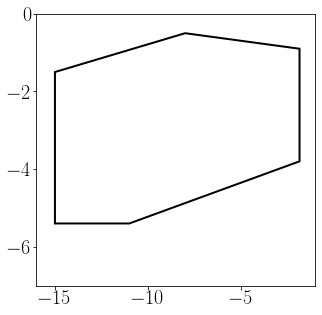

In [6]:
pm_polygon = np.array([[-15, -5.4],
                       [-15, -1.5],
                       [-8, -0.5],
                       [-1.85, -0.9],
                       [-1.85, -3.8],
                       [-11, -5.4]])
pp = mpl.patches.Polygon(pm_polygon, 
                         facecolor='none',edgecolor='k', linewidth=2)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.add_patch(pp)
ax.set_ylim(-7,0)
ax.set_xlim(-16,-1)

In [7]:
pm_points = np.vstack((pm1_all.value, pm2_all.value)).T
pm_mask = pp.get_path().contains_points(pm_points)

(0.0, 1.2)

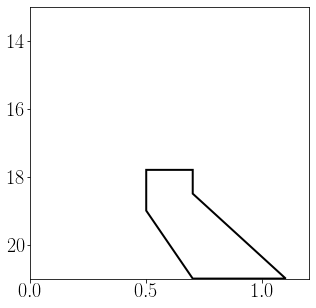

In [8]:
cm_polygon = np.array([[0.7, 21], 
                       [1.1, 21], 
                       [0.7, 18.5], 
                       [0.7, 17.8], 
                       [0.5, 17.8], 
                       [0.5, 19]])
cc = mpl.patches.Polygon(cm_polygon, 
                         facecolor='none',edgecolor='k', linewidth=2)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.add_patch(cc)
ax.set_ylim(21,13)
ax.set_xlim(0,1.2)

In [9]:
iso=pd.read_csv('../data/isochrones/ps1_isochrone_age12.4_z-1.5.csv')[15:110]

g0 = g_all['g_0']
i0 = g_all['i_0']

#creating a polygon by isochrone
iso_contour = np.concatenate((np.vstack([iso.gP1mag-iso.iP1mag +0.3, iso.gP1mag+0.3]).T, 
                np.flip(np.vstack([iso.gP1mag-iso.iP1mag -0.3, iso.gP1mag-0.3]).T, axis = 0)))

cc_iso = mpl.patches.Polygon(iso_contour, facecolor='none',edgecolor='k', linewidth=2)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.plot(iso.gP1mag-iso.iP1mag, iso.gP1mag+0.5)
ax.add_patch(cc_iso)
ax.set_ylim(7,-1.7)
ax.set_xlim(0,1.5)

FileNotFoundError: [Errno 2] No such file or directory: '../data/isochrones/ps1_isochrone_age12.4_z-1.5.csv'

In [ ]:
#for the rest of the stream which seems to be slightly farther than everything else
cm_points_iso = np.vstack([g_all.g_0-g_all.i_0, g_all.g_0 - 14.3]).T
cm_mask_iso = cc_iso.get_path().contains_points(cm_points_iso)

## Establish the basic masks
No need to run this more than once

In [25]:
final_phi1_mask = (phi1_all > -100) & (phi1_all < 20)

final_t = g_all.data[final_phi1_mask]
final_t['pm_mask'] = pm_mask[final_phi1_mask]
final_t['gi_cmd_mask'] = cm_mask_iso[final_phi1_mask]

final_t['phi1'] = phi1_all[final_phi1_mask]
final_t['phi2'] = phi2_all[final_phi1_mask]

#final_t['pm_phi1_cosphi2_no_reflex'] = pm1[final_phi1_mask]
#final_t['pm_phi2_no_reflex'] = pm2[final_phi1_mask]

final_t['pm_phi1_cosphi2'] = pm1_all[final_phi1_mask]
final_t['pm_phi2'] = pm2_all[final_phi1_mask]

len(final_t)

3675484

In [64]:
final_t.write('../data/gd1_ps1_with_basic_masks_wide.fits', overwrite=True)

## Can start running notebook here once basic masks have been established

In [10]:
gaia = GaiaData('../data/gd1_ps1_with_basic_masks_thin.fits')
g = gaia

In [11]:
stream_mask = g.gi_cmd_mask & g.pm_mask
g = g[(stream_mask) & (g.phi2>-8)]

In [12]:
bin_size = 4

bins_nonoverlap = np.arange(-90, (20-bin_size)+1, bin_size)
cen_phi1 = 0.5 * (bins_nonoverlap[:-1] + bins_nonoverlap[1:])

# median track
phi2_median, be, bn = binned_statistic((g.phi1), 
                                        g.phi2, 
                                        statistic='median', bins=bins_nonoverlap)
phi2_sum, be = np.histogram((g.phi1), 
                            bins=bins_nonoverlap)
phi2_median_err = np.abs(phi2_median) / np.sqrt(phi2_sum)

In [13]:

# apply manual corrections for the less bright sections closer to the edges
phi2_median[0] = -3.1
phi2_median[1] = -2.8
phi2_median[2] = -2.55
phi2_median[3] = -1.9
phi2_median[4] = -1.7
phi2_median[5] = -1.5
phi2_median[6] = -1.

phi2_median[-9] = -0.1

phi2_median[-2] = -2.1
phi2_median[-1] = -2.4

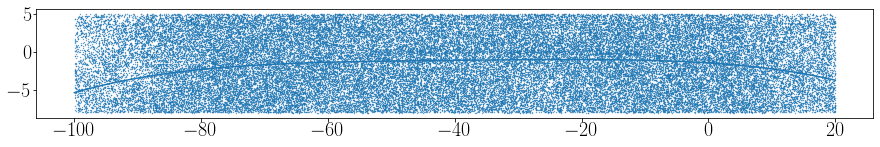

In [14]:
deg = 4
ptrack = np.polyfit(cen_phi1, phi2_median, deg, w=1 / np.sqrt(phi2_sum))
polytrack = np.poly1d(ptrack)
phi1_ = np.linspace(-100, 20, 100)
phi2_ = polytrack(phi1_)

plt.figure(figsize=(15,2))
plt.scatter(g.phi1, g.phi2, s=0.1)
plt.plot(phi1_,phi2_)

In [15]:
#np.save('data/gd1_track.npy', np.stack((phi1_,phi2_)).T)

In [16]:
track = np.load('../data/gd1_track.npy')
phi1_ = np.load('../data/phi1_stream_from_pm_model.npy')

from scipy.interpolate import UnivariateSpline
#phi1_ = gaia[gaia.phi1.argsort()].phi1
phi2_spline = UnivariateSpline(phi1_, track, k=5)
phi1_trace = np.linspace(-100, 20, 30)
phi2_trace = phi2_spline(phi1_trace)

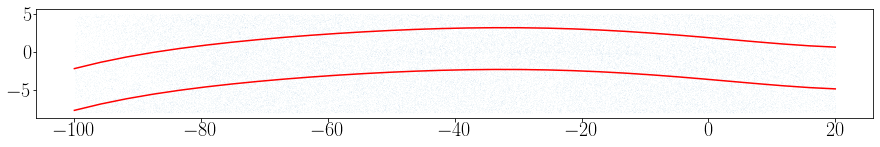

In [17]:
# stream selection
plt.figure(figsize=(15,2))
plt.scatter(g.phi1, g.phi2, s=0.0001)
plt.plot(phi1_trace,phi2_trace+3, c='red')
plt.plot(phi1_trace,phi2_trace-2.5, c='red')

(-10.0, 5.0)

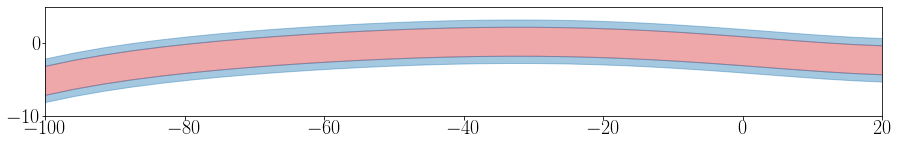

In [18]:
#slightly off center because we want to make sure we include the spur
stream_top = np.vstack([phi1_trace, phi2_trace + 2]).T #can't go lower than this, spur is aabout 1.25 above track
stream_bottom = np.vstack([phi1_trace, phi2_trace - 2]).T
gd1_poly = np.vstack((stream_top, stream_bottom[::-1]))
gd1_phi_path = mpl.path.Path(gd1_poly)

offstream_above_top = np.vstack([phi1_trace, phi2_trace + 3]).T
offstream_above_bottom = np.vstack([phi1_trace, phi2_trace + 2]).T
ctl_poly1 = np.vstack((offstream_above_top, offstream_above_bottom[::-1]))

offstream_below_top =np.vstack([phi1_trace,  phi2_trace-2]).T
offstream_below_bottom = np.vstack([phi1_trace, phi2_trace-3]).T
ctl_poly2 = np.vstack((offstream_below_top, offstream_below_bottom[::-1]))

ctl_phi_path = [mpl.path.Path(ctl_poly1),
                mpl.path.Path(ctl_poly2)]

fig, ax = plt.subplots(1,1,figsize=(15,2))
ax.add_patch(mpl.patches.Polygon(gd1_phi_path.vertices, color='tab:red', alpha=0.4))
ax.add_patch(mpl.patches.Polygon(ctl_phi_path[0].vertices, color='tab:blue', alpha=0.4))
ax.add_patch(mpl.patches.Polygon(ctl_phi_path[1].vertices, color='tab:blue', alpha=0.4))
#ax.scatter(g.phi1, g.phi2, s=0.1)
ax.set_xlim(-100, 20)
ax.set_ylim(-10, 5)

In [19]:
# these three arrays taken from the on_off_stream_sel_and_plots notebook
pm1_track   = [-7.4, -9.5, -10.5, -12 , -13 , -13.3, -13 , -12.2, -10.5, -9  , -8, -7]
pm2_track   = [-3.3, -3.5, -3.7 , -3.7, -3.7, -3.5 , -3.2, -3   , -2.5 , -2.3, -2, -2]
phi1_for_pm = [-95 , -85 , -75  , -65 , -55 , -45  , -35 , -25  , -15  , -5  , 5 , 15]

pm_nodes = np.arange(-100, 20+1e-3, 15.)

interp_pm1 = InterpolatedUnivariateSpline(phi1_for_pm, 
                                          pm1_track, k=3)
interp_pm2 = InterpolatedUnivariateSpline(phi1_for_pm, 
                                          pm2_track, k=3)

_interp_pm1 = InterpolatedUnivariateSpline(pm_nodes, interp_pm1(pm_nodes), 
                                           k=3, bbox=[-100, 20])
_interp_pm2 = InterpolatedUnivariateSpline(pm_nodes, interp_pm2(pm_nodes), 
                                           k=3, bbox=[-100, 20])

In [20]:
X = np.stack((g.phi1, g.phi2)).T
X_pm = np.stack((g.pm_phi1_cosphi2.value, g.pm_phi2.value)).T

sky_gd1_mask = gd1_phi_path.contains_points(X)
sky_ctl_mask = ctl_phi_path[0].contains_points(X) | ctl_phi_path[1].contains_points(X)

(-7.0, 5.0)

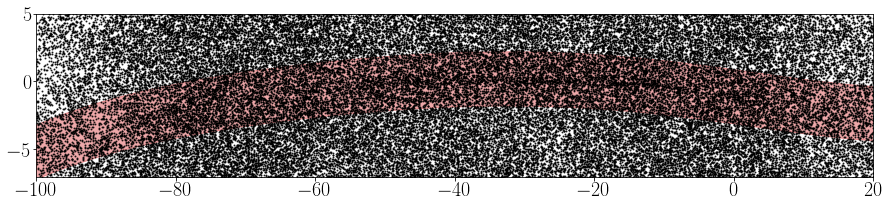

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(g.phi1[g.gi_cmd_mask & g.pm_mask], 
        g.phi2[g.gi_cmd_mask & g.pm_mask], 
        ls='none', marker='o', color='k', 
        alpha=0.75, ms=1)

ax.add_patch(mpl.patches.Polygon(gd1_phi_path.vertices, color='tab:red', alpha=0.4))
# ax.add_patch(mpl.patches.Polygon(ctl_phi_path[0].vertices, color='tab:blue', alpha=0.4))
# ax.add_patch(mpl.patches.Polygon(ctl_phi_path[1].vertices, color='tab:blue', alpha=0.4))

ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

In [22]:
gaia = GaiaData('../data/gd1_ps1_with_basic_masks_thin.fits')
#gaia = GaiaData('../data/gd1_pass_cuts.fits')

stream_mask = gaia.gi_cmd_mask
g = gaia[(stream_mask)]# & (gaia.g_0 < 18)]
g = gaia

dist = g.get_distance(min_parallax=1e-3*u.mas)
c = g.get_skycoord(distance=dist)
stream_coord = c.transform_to(gc.GD1)
phi1 = stream_coord.phi1.degree
phi2 = stream_coord.phi2.degree
pm1 = stream_coord.pm_phi1_cosphi2
pm2 = stream_coord.pm_phi2

In [23]:
g_color = g[np.isfinite(g.parallax) & (g.parallax > 0) & np.isfinite(pm2)]
dist = g_color.get_distance(min_parallax=1e-3*u.mas)
c1 = g_color.get_skycoord(distance=dist)
stream_coord = c1.transform_to(gc.GD1)
phi1_color = stream_coord.phi1.degree
phi2_color = stream_coord.phi2.degree
pm1_color = stream_coord.pm_phi1_cosphi2
pm2_color = stream_coord.pm_phi2
g_color

<GaiaData: 3675484 rows>

In [106]:
X_color = np.stack((phi1_color, phi2_color)).T
X_pm_color = np.stack((pm1_color.value, pm2_color.value)).T

c = g_color.get_skycoord(distance=False)

Cov_color = g_color.get_cov()[:, 3:5, 3:5]
Cov_pm_color = gc.transform_pm_cov(c, Cov_color, gc.GD1)

sky_gd1_mask_color = gd1_phi_path.contains_points(X_color)
sky_ctl_mask_color = ctl_phi_path[0].contains_points(X_color) | ctl_phi_path[1].contains_points(X_color)

  0%|                                                    | 0/12 [00:00<?, ?it/s]

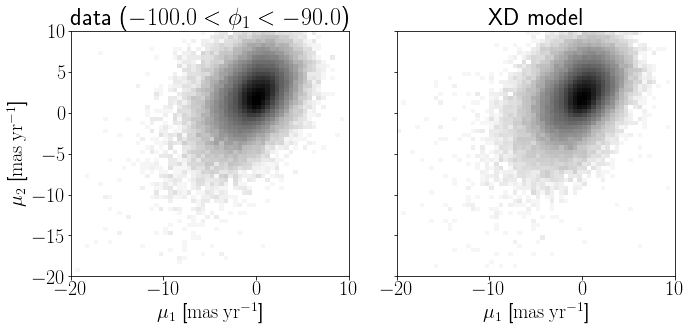

  8%|███▎                                    | 1/12 [28:10<5:09:57, 1690.69s/it]

       phi1                phi2        ... gi_cmd_mask    pm_ln_bkg_prob  
                                       ...                                
------------------ ------------------- ... ----------- -------------------
-99.99998974953799  -9.401555369237643 ...       False  -3.672321295842991
-99.99998957904452  -5.823224474521122 ...       False -2.3446041777673883
-99.99998750084802  3.2922805742688688 ...        True -2.2818418162659184
-99.99998617237851  3.7325179121404357 ...       False -2.5939179852477374
-99.99998310574392  2.3594273980440588 ...       False -2.5804736146850087
-99.99998202918728  -4.729791338825707 ...        True    -2.9588472352317
               ...                 ... ...         ...                 ...
-90.00007182629702  -6.188679092589318 ...       False  -7.102239389213288
-90.00005845008988  -5.175713369589816 ...       False    -4.5196275644249
-90.00005753960613  3.2204577166506203 ...        True -3.8312570542509166
-90.00005011881157 -1.116

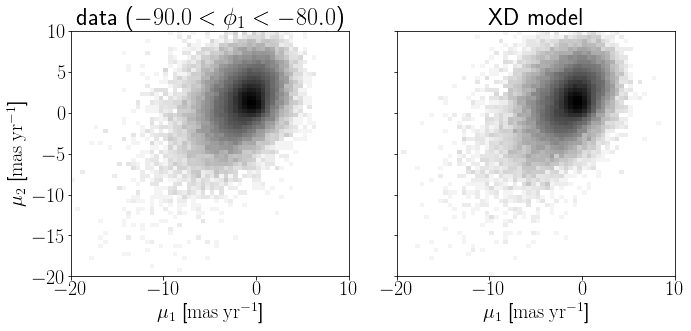

 17%|██████▎                               | 2/12 [1:21:38<7:10:28, 2582.84s/it]

       phi1                phi2        ... gi_cmd_mask    pm_ln_bkg_prob  
                                       ...                                
------------------ ------------------- ... ----------- -------------------
-99.99998974953799  -9.401555369237643 ...       False  -3.672321295842991
-99.99998957904452  -5.823224474521122 ...       False -2.3446041777673883
-99.99998750084802  3.2922805742688688 ...        True -2.2818418162659184
-99.99998617237851  3.7325179121404357 ...       False -2.5939179852477374
-99.99998310574392  2.3594273980440588 ...       False -2.5804736146850087
-99.99998202918728  -4.729791338825707 ...        True    -2.9588472352317
               ...                 ... ...         ...                 ...
-80.00008793480927   3.697183082661741 ...        True  -4.415657557251441
-80.00007530664367 -3.3079982273542416 ...        True -2.9361759220165258
-80.00007294238705 -2.2664261494116853 ...       False -2.6234614732521537
-80.00006885592789   4.22

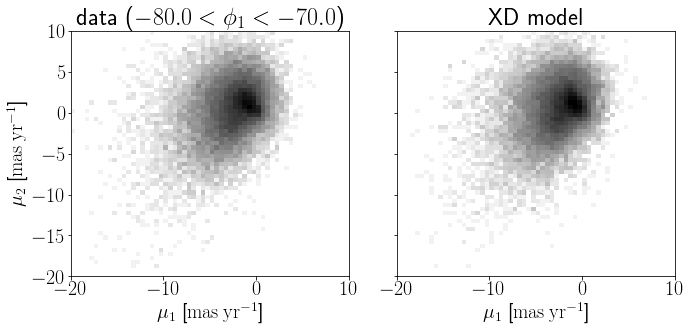

 25%|█████████▌                            | 3/12 [2:01:36<6:14:46, 2498.49s/it]

       phi1                phi2        ... gi_cmd_mask    pm_ln_bkg_prob  
                                       ...                                
------------------ ------------------- ... ----------- -------------------
-99.99998974953799  -9.401555369237643 ...       False  -3.672321295842991
-99.99998957904452  -5.823224474521122 ...       False -2.3446041777673883
-99.99998750084802  3.2922805742688688 ...        True -2.2818418162659184
-99.99998617237851  3.7325179121404357 ...       False -2.5939179852477374
-99.99998310574392  2.3594273980440588 ...       False -2.5804736146850087
-99.99998202918728  -4.729791338825707 ...        True    -2.9588472352317
               ...                 ... ...         ...                 ...
-70.00048925738946  -8.817253206553993 ...       False  -4.512659046211132
-70.00044521606604  -7.612468540107159 ...       False -4.9622558791920115
-70.00042197991091  -3.273971906954226 ...       False  -3.863410532446335
-70.00040155896859 -1.502

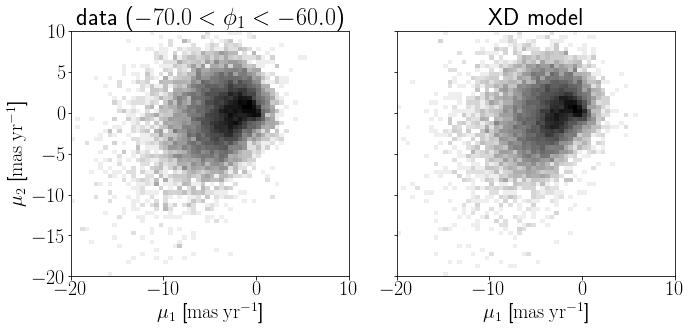

 33%|████████████▋                         | 4/12 [2:03:58<3:29:06, 1568.32s/it]

       phi1                phi2        ... gi_cmd_mask    pm_ln_bkg_prob  
                                       ...                                
------------------ ------------------- ... ----------- -------------------
-99.99998974953799  -9.401555369237643 ...       False  -3.672321295842991
-99.99998957904452  -5.823224474521122 ...       False -2.3446041777673883
-99.99998750084802  3.2922805742688688 ...        True -2.2818418162659184
-99.99998617237851  3.7325179121404357 ...       False -2.5939179852477374
-99.99998310574392  2.3594273980440588 ...       False -2.5804736146850087
-99.99998202918728  -4.729791338825707 ...        True    -2.9588472352317
               ...                 ... ...         ...                 ...
-60.00049665224247   4.019323728328535 ...        True -3.7529949811787793
-60.00028865571593   3.092626155896407 ...       False  -5.081449940998797
-60.00013699265718  3.7005281248759485 ...       False  -4.684124608546969
-60.00010198236169   2.57

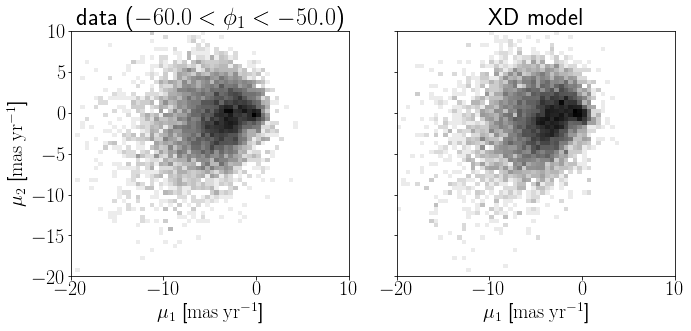

 42%|███████████████▊                      | 5/12 [2:05:26<2:00:40, 1034.39s/it]

        phi1                phi2         ... gi_cmd_mask    pm_ln_bkg_prob  
                                         ...                                
------------------- -------------------- ... ----------- -------------------
 -99.99998974953799   -9.401555369237643 ...       False  -3.672321295842991
 -99.99998957904452   -5.823224474521122 ...       False -2.3446041777673883
 -99.99998750084802   3.2922805742688688 ...        True -2.2818418162659184
 -99.99998617237851   3.7325179121404357 ...       False -2.5939179852477374
 -99.99998310574392   2.3594273980440588 ...       False -2.5804736146850087
 -99.99998202918728   -4.729791338825707 ...        True    -2.9588472352317
                ...                  ... ...         ...                 ...
-50.000719819938766   -1.651824166113697 ...       False  -5.194481954737884
 -50.00069745951206   -8.760333831268701 ...        True  -5.738686340505443
 -50.00065069862682   0.5515226608135158 ...       False -5.6394087260396235

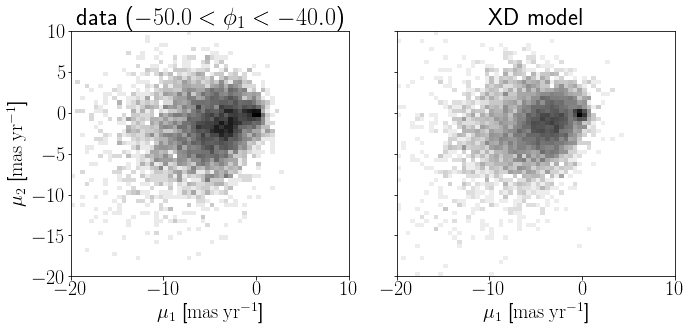

 50%|███████████████████▌                   | 6/12 [2:06:25<1:10:16, 702.74s/it]

       phi1                phi2        ... gi_cmd_mask    pm_ln_bkg_prob  
                                       ...                                
------------------ ------------------- ... ----------- -------------------
-99.99998974953799  -9.401555369237643 ...       False  -3.672321295842991
-99.99998957904452  -5.823224474521122 ...       False -2.3446041777673883
-99.99998750084802  3.2922805742688688 ...        True -2.2818418162659184
-99.99998617237851  3.7325179121404357 ...       False -2.5939179852477374
-99.99998310574392  2.3594273980440588 ...       False -2.5804736146850087
-99.99998202918728  -4.729791338825707 ...        True    -2.9588472352317
               ...                 ... ...         ...                 ...
 -40.0009947249586  2.6781941072501834 ...       False  -8.049786028194397
-40.00040463885545  -2.766934884028556 ...       False    -5.1453476693003
-40.00027007091762 -4.6630026502416015 ...        True  -4.544457606483616
-40.00015191855078   1.01

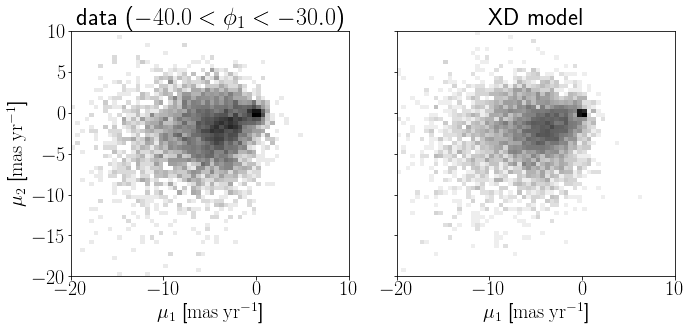

 58%|███████████████████████▉                 | 7/12 [2:07:18<40:52, 490.53s/it]

        phi1                phi2        ... gi_cmd_mask    pm_ln_bkg_prob  
                                        ...                                
------------------- ------------------- ... ----------- -------------------
 -99.99998974953799  -9.401555369237643 ...       False  -3.672321295842991
 -99.99998957904452  -5.823224474521122 ...       False -2.3446041777673883
 -99.99998750084802  3.2922805742688688 ...        True -2.2818418162659184
 -99.99998617237851  3.7325179121404357 ...       False -2.5939179852477374
 -99.99998310574392  2.3594273980440588 ...       False -2.5804736146850087
 -99.99998202918728  -4.729791338825707 ...        True    -2.9588472352317
                ...                 ... ...         ...                 ...
  -30.0006365341714  1.7019823195212018 ...       False  -5.367709170862052
-30.000509430086378  1.7312811939342734 ...       False  -8.125848111334287
-30.000362665453892  -3.639034038801591 ...       False  -9.067674421414468
-30.00031127

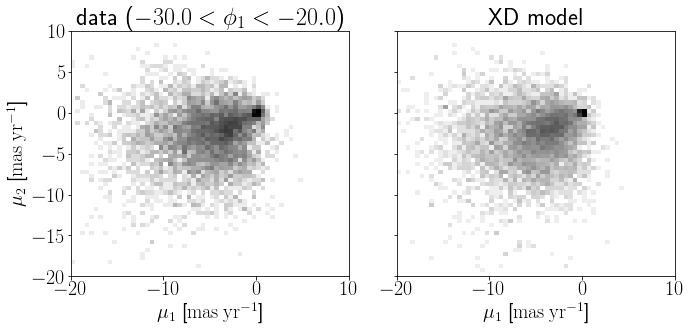

 67%|███████████████████████████▎             | 8/12 [2:08:17<23:32, 353.14s/it]

        phi1                phi2        ... gi_cmd_mask    pm_ln_bkg_prob  
                                        ...                                
------------------- ------------------- ... ----------- -------------------
 -99.99998974953799  -9.401555369237643 ...       False  -3.672321295842991
 -99.99998957904452  -5.823224474521122 ...       False -2.3446041777673883
 -99.99998750084802  3.2922805742688688 ...        True -2.2818418162659184
 -99.99998617237851  3.7325179121404357 ...       False -2.5939179852477374
 -99.99998310574392  2.3594273980440588 ...       False -2.5804736146850087
 -99.99998202918728  -4.729791338825707 ...        True    -2.9588472352317
                ...                 ... ...         ...                 ...
-20.000738112858848  -9.086956890270413 ...       False  -6.211695084980698
-20.000672617530377 -1.7355565747672879 ...       False  -7.279532489972035
-20.000528785459128  -8.176738924381697 ...       False  -4.966700627987668
 -20.0005017

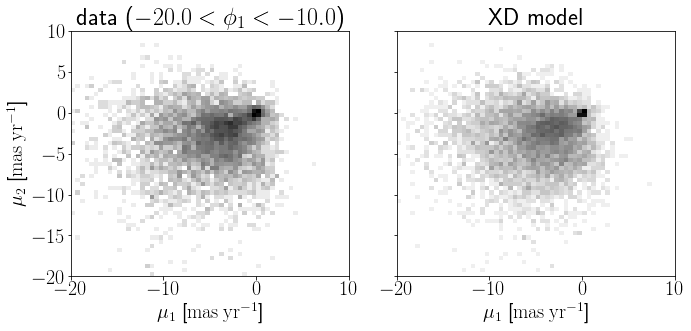

 75%|██████████████████████████████▊          | 9/12 [2:09:17<13:04, 261.45s/it]

        phi1                phi2        ... gi_cmd_mask    pm_ln_bkg_prob  
                                        ...                                
------------------- ------------------- ... ----------- -------------------
 -99.99998974953799  -9.401555369237643 ...       False  -3.672321295842991
 -99.99998957904452  -5.823224474521122 ...       False -2.3446041777673883
 -99.99998750084802  3.2922805742688688 ...        True -2.2818418162659184
 -99.99998617237851  3.7325179121404357 ...       False -2.5939179852477374
 -99.99998310574392  2.3594273980440588 ...       False -2.5804736146850087
 -99.99998202918728  -4.729791338825707 ...        True    -2.9588472352317
                ...                 ... ...         ...                 ...
-10.000721088353432  -4.064551735727374 ...       False -4.2350763064315196
-10.000672687554449 -2.5610824945058384 ...       False -7.5020503410418815
-10.000365200154272 -6.6527805452115585 ...        True  -4.748842612670125
-10.00028579

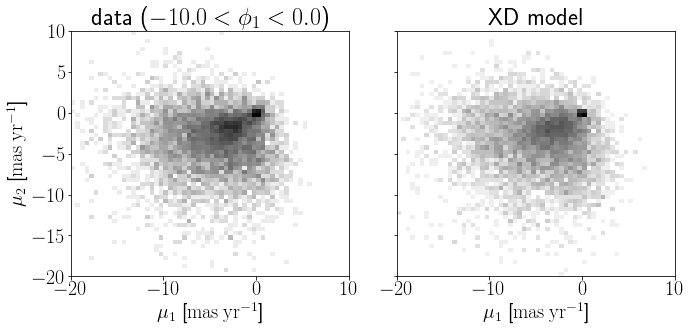

 83%|█████████████████████████████████▎      | 10/12 [2:10:21<06:41, 200.62s/it]

          phi1                  phi2        ... gi_cmd_mask    pm_ln_bkg_prob  
                                            ...                                
----------------------- ------------------- ... ----------- -------------------
     -99.99998974953799  -9.401555369237643 ...       False  -3.672321295842991
     -99.99998957904452  -5.823224474521122 ...       False -2.3446041777673883
     -99.99998750084802  3.2922805742688688 ...        True -2.2818418162659184
     -99.99998617237851  3.7325179121404357 ...       False -2.5939179852477374
     -99.99998310574392  2.3594273980440588 ...       False -2.5804736146850087
     -99.99998202918728  -4.729791338825707 ...        True    -2.9588472352317
                    ...                 ... ...         ...                 ...
 -0.0007735022336323086   2.998576987816221 ...       False -5.0200262898424475
 -0.0007696538468923812 -1.2104383655839235 ...       False  -5.096018577927926
 -0.0007396321699959407  1.6454688455052

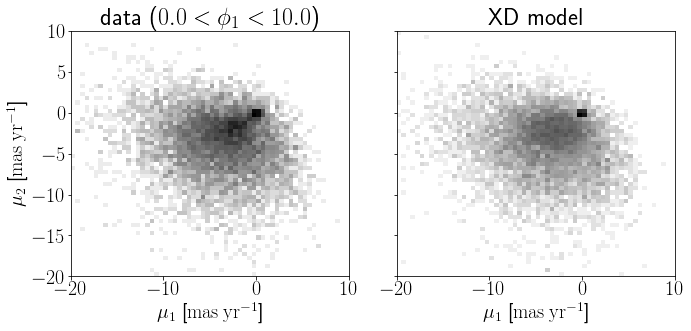

 92%|████████████████████████████████████▋   | 11/12 [2:11:49<02:46, 166.04s/it]

       phi1                phi2        ... gi_cmd_mask    pm_ln_bkg_prob  
                                       ...                                
------------------ ------------------- ... ----------- -------------------
-99.99998974953799  -9.401555369237643 ...       False  -3.672321295842991
-99.99998957904452  -5.823224474521122 ...       False -2.3446041777673883
-99.99998750084802  3.2922805742688688 ...        True -2.2818418162659184
-99.99998617237851  3.7325179121404357 ...       False -2.5939179852477374
-99.99998310574392  2.3594273980440588 ...       False -2.5804736146850087
-99.99998202918728  -4.729791338825707 ...        True    -2.9588472352317
               ...                 ... ...         ...                 ...
 9.999137852114643   2.242422857521756 ...        True  -5.368744770745884
 9.999149154022579  3.0877276903672013 ...       False   -4.57638990948187
 9.999196134800457  2.5489903441591126 ...        True  -4.912848524132562
 9.999249910604423   -3.4

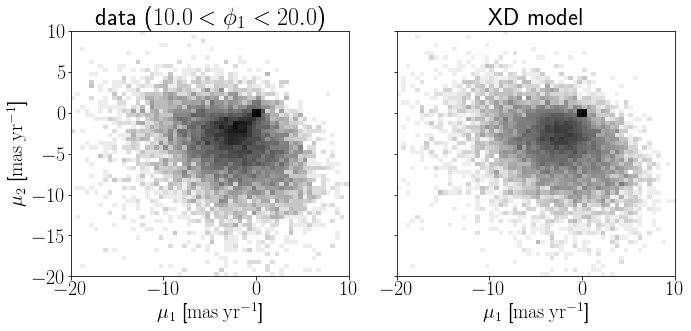

100%|████████████████████████████████████████| 12/12 [2:14:13<00:00, 671.11s/it]

       phi1                phi2        ... gi_cmd_mask    pm_ln_bkg_prob  
                                       ...                                
------------------ ------------------- ... ----------- -------------------
-99.99998974953799  -9.401555369237643 ...       False  -3.672321295842991
-99.99998957904452  -5.823224474521122 ...       False -2.3446041777673883
-99.99998750084802  3.2922805742688688 ...        True -2.2818418162659184
-99.99998617237851  3.7325179121404357 ...       False -2.5939179852477374
-99.99998310574392  2.3594273980440588 ...       False -2.5804736146850087
-99.99998202918728  -4.729791338825707 ...        True    -2.9588472352317
               ...                 ... ...         ...                 ...
19.999244383864095  0.6204059659728043 ...        True  -4.620578113539141
  19.9993125252998   2.676978728217882 ...       False -7.8081472877870235
19.999328167376447  -4.815731934903779 ...       False  -5.390384663352371
19.999556607452373  -5.50

In [109]:
phi1_bins = np.arange(-100, 20+1e-3, 10)
pm_bins = np.arange(-20, 10+1e-3, 0.5)

gmms = []
all_tbl = Table()
for i in trange(len(phi1_bins)-1):
    l, r = phi1_bins[i], phi1_bins[i+1]
    phi1_mask = (phi1_color >= l) & (phi1_color < r)
    g_new = g_color[phi1_mask]
    control_mask = phi1_mask & sky_ctl_mask_color
    
    X_pm_ctl = X_pm_color[control_mask]
    C_pm_ctl = Cov_pm_color[control_mask]
    
    # MAGIC NUMBER: 4-5 from experimenting with the BIC
    gmm = XDGMM(n_components=8, method='Bovy')
    _ = gmm.fit(X_pm_ctl, C_pm_ctl)
    scores, _ = gmm.score_samples(X_pm_color[phi1_mask], Cov_pm_color[phi1_mask])
    #np.save('../data/score_samples/score_samples_wide_{}_to_{}.npy'.format(int(l), int(r)), scores)
    
    gmms.append(gmm)
    
    # ---
    tbl = Table()
    tbl['phi1'] = g_new['phi1']
    tbl['phi2'] = g_new['phi2']
    tbl['pm1'] = g_new['pm_phi1_cosphi2']
    tbl['pm2'] = g_new['pm_phi2']
    tbl['g_0'] = g_new['g_0']
    tbl['i_0'] = g_new['i_0']
    tbl['pm_mask'] = g_new['pm_mask']
    tbl['gi_cmd_mask'] = g_new['gi_cmd_mask']
    tbl['pm_ln_bkg_prob'] = scores
    all_tbl = vstack([all_tbl, tbl])
    
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5),
                             sharex=True, sharey=True)

    ax = axes[0]
    H, xe, ye = np.histogram2d(X_pm_ctl[:, 0], X_pm_ctl[:, 1],
                               bins=pm_bins)
    ax.pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm())

    ax = axes[1]
    _samples = gmm.sample(size=len(X_pm_ctl))
    H, xe, ye = np.histogram2d(_samples[:, 0], _samples[:, 1],
                               bins=pm_bins)
    ax.pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm())
    
    axes[0].set_xlabel(r'$\mu_1$ [{:latex_inline}]'.format(u.mas/u.yr))
    axes[0].set_ylabel(r'$\mu_2$ [{:latex_inline}]'.format(u.mas/u.yr))
    axes[1].set_xlabel(r'$\mu_1$ [{:latex_inline}]'.format(u.mas/u.yr))
    axes[0].set_title(r'data (${:.1f} < \phi_1 < {:.1f}$)'.format(l, r))
    axes[1].set_title(r'XD model')
    fig.tight_layout()
    plt.show()
    print(all_tbl)

In [110]:
all_tbl.write('../data/pm_member_prob_all_stars_8comp.fits', overwrite=True)
bkg_table = Table.read('../data/pm_member_prob_all_stars_8comp.fits')
sorted_table = bkg_table[bkg_table['phi1'].argsort()]
sorted_table.write('../data/sorted_pm_member_prob_all_stars_8comp.fits', overwrite=True)

In [24]:
bkg_table = Table.read('../data/pm_member_prob_all_stars_8comp.fits')
print(len(bkg_table))

3675484
